<a href="https://colab.research.google.com/github/Sebasu11/MedellinAIMeetUp_LETOR/blob/main/LearningToRank_Meli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LETOR (Learning To Rank)



# pip install

instalamos las siguientes librerias

In [ ]:
!pip install watermark -q
!pip install lightgbm -U -q
!pip install "embetter[text]" -q
!pip install xgboost==2.0.0
!pip install rank_bm25 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.1/590.1 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 106.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 121.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 106.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.4 MB/s 

# Datos

Los datos pertenecen a un Challenge de MercadoLibre para el cual el objetivo era calcular ese NextItemToBuy utilizando el Journey de Navegación de una persona.

Ya son de uso publico y los pueden encontrar en el siguiente link :

In [ ]:
!mkdir data
!cp drive/MyDrive/MeetUp_ML/MeliDataChallenge2020.zip data/MeliDataChallenge2020.zip
!unzip data/MeliDataChallenge2020.zip -d data/

Archive:  data/MeliDataChallenge2020.zip
  inflating: data/item_data.jl       
  inflating: data/sample_submission.csv  
  inflating: data/test_dataset.jl    
  inflating: data/train_dataset.jl   


# Librerias

In [ ]:
from watermark import watermark
import pandas as pd
import numpy as np

In [ ]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [ ]:
%load_ext watermark

In [ ]:
%watermark

Last updated: 2023-10-27T20:16:14.491522+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.120+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



In [ ]:
# versiones
print(watermark(packages="pandas,scikit-learn,lightgbm,xgboost,rank_bm25,embetter"))

pandas      : 1.5.3
scikit-learn: 1.2.2
lightgbm    : 4.1.0
xgboost     : 2.0.0
rank_bm25   : 0.2.2
embetter    : 0.5.4



# data

In [ ]:
%%time
data = pd.read_json('data/train_dataset.jl', lines=True)
data.columns = [col.upper() for col in data.columns]

items = pd.read_json('data/item_data.jl', lines=True)
items.columns = [col.upper() for col in items.columns]

CPU times: user 24.3 s, sys: 8.38 s, total: 32.7 s
Wall time: 32.3 s


In [ ]:
data.sample(4)

,USER_HISTORY,ITEM_BOUGHT
362622,"[{'event_info': 838831, 'event_timestamp': '20...",1352418
373535,"[{'event_info': 'PASTA DENTAL FLUOR', 'event_t...",1758312
170879,"[{'event_info': 144532, 'event_timestamp': '20...",539137
272971,"[{'event_info': 108317, 'event_timestamp': '20...",1075129


In [ ]:
data.iloc[[1]].style

,USER_HISTORY,ITEM_BOUGHT
1,"[{'event_info': 643652, 'event_timestamp': '2019-10-06T18:02:53.893-0400', 'event_type': 'view'}, {'event_info': 'DESMAMADEIRA ELETRICA', 'event_timestamp': '2019-10-07T09:45:29.322-0400', 'event_type': 'search'}, {'event_info': 1156086, 'event_timestamp': '2019-10-07T09:46:07.960-0400', 'event_type': 'view'}, {'event_info': 'DESMAMADEIRA ELETRICA', 'event_timestamp': '2019-10-07T09:46:17.100-0400', 'event_type': 'search'}, {'event_info': 'DESMAMADEIRA ELETRICA', 'event_timestamp': '2019-10-07T09:46:19.173-0400', 'event_type': 'search'}, {'event_info': 1943604, 'event_timestamp': '2019-10-07T09:47:53.958-0400', 'event_type': 'view'}, {'event_info': 'DESMAMADEIRA ELETRICA', 'event_timestamp': '2019-10-07T18:53:20.113-0400', 'event_type': 'search'}, {'event_info': 206667, 'event_timestamp': '2019-10-07T18:53:26.670-0400', 'event_type': 'view'}, {'event_info': 'DESMAMADEIRA ELETRICA', 'event_timestamp': '2019-10-07T18:54:36.944-0400', 'event_type': 'search'}, {'event_info': 1282813, 'event_timestamp': '2019-10-07T18:54:50.998-0400', 'event_type': 'view'}, {'event_info': 228737, 'event_timestamp': '2019-10-07T18:56:43.678-0400', 'event_type': 'view'}, {'event_info': 228737, 'event_timestamp': '2019-10-07T19:01:44.718-0400', 'event_type': 'view'}, {'event_info': 228737, 'event_timestamp': '2019-10-07T19:46:18.382-0400', 'event_type': 'view'}]",228737


# PROBLEM

Un dia uno de nuestros stakeholders tuvo la gran idea de porque no usar el Journey de Navegación, ordenarlo y recordar a las personas de esas ventas con la hipotesis de que eso indirectamente impulsaria las ventas.

Ahora, para esto tendremos que identificar que estaba buscando el usuario y que fue lo que vio, por lo que utilizaremos el ultimo search para identificar la "intención de busqueda".

Entonces : Vamos a recomendar items de MeLi a partir del ultimo search por el usuario.
 * Los itemas a rankear seran los vistos en su Journey de Navegación.








**NOTA !**

"Que quede muy claro que el problema que voy a presentar es ficción y no tiene ninguna relación con el funcionamiento interno de MercadoLibre, cualquier similitud con features, procesamiento y modelos es pura coincidencia, este ejercicio es completamente imaginario y no refleja de ninguna manera la realidad de cómo opera MercadoLibre en la vida real.

# STEPS :

* Rank Format (Preparación de datos)
* Como medir un Ranker?
* Tips.
* Learning Ranking (Modelos)


### Formato Ranker

Usemos la siguiente nomenclatura:
* Donde $Q = \{q_1, \dots, q_n\}$ sera el conjunto de grupos
* $D_q = \{d_{q1}, \dots, d_{qm}\}$ -- conjunto de objetos para cada grupo (retreival) $q$
* $L_q = \{l_{q1}, \dots, l_{qm}\}$ -- relevancia para cada uno de los objetos de cada grupo $D_q$

Cada objeto $d_{qi}$ está representado en un espacio vectorial de caracteristicas (features) para describir la relación entre el grupo y el objeto.

Por Ejemplo, cada grupo aqui corresponde a los items vistos dentro del journey de navegación partiendo del search como query.

La meta es poder generar una función de ranking $f = f(d_{qi})$, donde el rankeo de los items $d_{qi}$ para todos los grupos de  $Q$ basados en sus scores $x_{qi} = f(d_{qi})$, sean los más cercanos posibles al ranking ideal $l_{qi}$.

y donde el objetivo es llegar a lo siguiente :

$$\begin{pmatrix}
    d_1, q_1, f_1\\
    d_4, q_1, f_4\\
    d_2, q_2, f_2\\
    d_3, q_2, f_3\\
    d_5, q_2, f_5\\
\end{pmatrix} \hspace{6px} \texttt{or} \hspace{6px}
\begin{pmatrix}
    d_2, q_2, f_2\\
    d_3, q_2, f_3\\
    d_5, q_2, f_5\\
    d_1, q_1, f_1\\
    d_4, q_1, f_4\\
\end{pmatrix}$$

donde $f_i$ es el vector de features para el documento i-th.

## Relevancia

* Manual (Etiquetar datos):

Una forma de generar el objetivo de relevancia es recopilar datos de ejemplo y pedir a expertos humanos  que asignen la relevancia de los resultados de búsqueda.

Los expertos asignan puntajes a cada resultado, generalmente en una escala, como 1 (poco relevante) a 5 (muy relevante).
Estos puntajes asignados por humanos se convierten en el target que el modelo de machine learning aprenderá a predecir.

    * PRO:
      - No necesita de un historico.
      - Se garantiza el ordenamiento deseado.

    * CON:
      - Muy costoso y lento.
      - Sesgo de los expertos.
  

* Interacciones del Usuario:

Otra forma de generar el target de relevancia es observar el comportamiento de los usuarios reales, para nuestro caso seria en nuestro marketplace.

Aqui podemos hacer seguimiento a los clicks de los usuarios después de realizar alguna acción (SEARCH, VIEW, BUY, ADD).

    * PRO:
      - Tenemos mucha y de facil acceso.
    
    * CON:
      - Hay mucho ruido del comportamiento.

Para nuestro caso, asumamos que el target va a ser binario, `1`si el ITEM es comprado y `0` en caso de que no.

## TIP 1 : NO Machine Learning

Al pensar asi, nos ayuda a definir como evaluar si lo que estamos ordenando está bien, en lo posible deberia ser agnostico a la solución.

Entonces si vamos a crear un Ranker sin modelo, de igual forma deberiamos ser capaces de evaluarlo.

# BASELINE !

* Aleatorio

* Last Item View

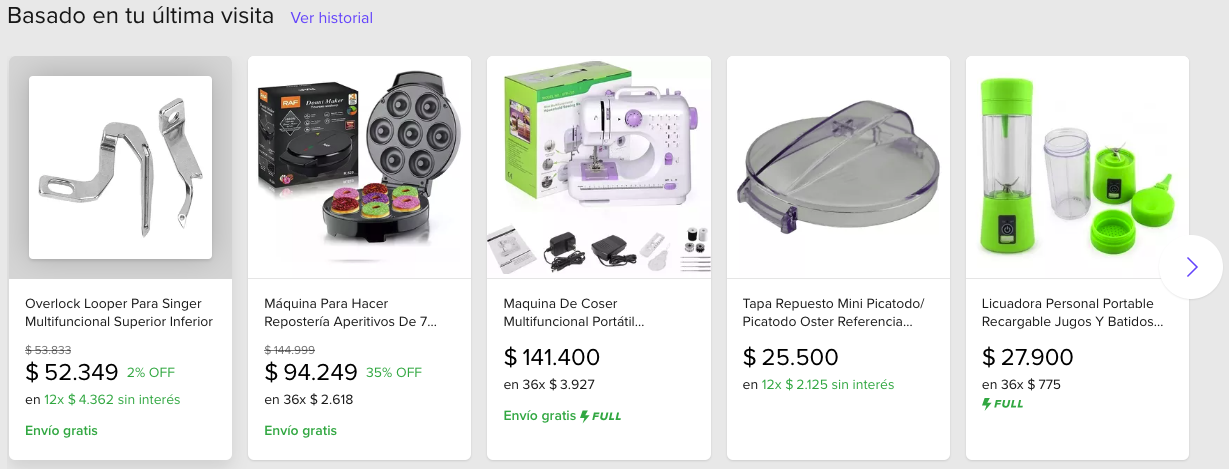

* Most View

* Most Similar?
* ....
* ..
* Trending

In [ ]:
def start_pipe(dataframe):
  return dataframe.copy()

def to_explode(dataframe, columns='USER_HISTORY'):

  dataframe = dataframe.assign(DOCUMENT_ID=(lambda d:np.arange(0, len(d)))).explode(columns)

  return dataframe

def get_events(dataframe):

  dataframe = dataframe.assign(RECO=(lambda d:d['USER_HISTORY'].apply(lambda x:x['event_info'])),
                                TIMESTAMP=(lambda d:d['USER_HISTORY'].apply(lambda x:pd.to_datetime(x['event_timestamp']))),
                                TYPE=(lambda d:d['USER_HISTORY'].apply(lambda x:x['event_type'])),
                                FLAG_IN_HISTORY=(lambda d:(d['RECO']==d['ITEM_BOUGHT']).astype('int8'))

                                )

  return dataframe


def filter_reco_history(dataframe):

  ids = dataframe.groupby(['DOCUMENT_ID'])['FLAG_IN_HISTORY'].max().loc[lambda x:x>0].index

  dataframe = dataframe.loc[lambda d:d['DOCUMENT_ID'].isin(ids)]

  return dataframe

def ranking_format(dataframe):

  dataframe = (dataframe.groupby(['DOCUMENT_ID', 'TYPE', 'ITEM_BOUGHT'], as_index=False)
                          .agg(RECOS=('RECO', lambda x:pd.Series(list(x)).drop_duplicates().tolist()),
                               RECOS_COUNTS=('RECO', lambda x:pd.Series(list(x)).tolist()),
                               TIMESTAMPS=('TIMESTAMP', lambda x:list(x))
                               )
                          .pivot(index=['DOCUMENT_ID', 'ITEM_BOUGHT'], columns=['TYPE'], values=['RECOS', 'RECOS_COUNTS', 'TIMESTAMPS'])

               )

  return dataframe

In [ ]:
%%time
baseline = (data.head(100_000)
          .pipe(start_pipe)
          .pipe(to_explode)
          .pipe(get_events)
          .pipe(filter_reco_history)
          .sort_values(['DOCUMENT_ID', 'TIMESTAMP'], ascending=[True, False])
          .pipe(ranking_format)
)
baseline.columns = ['_'.join(col) for col in baseline.columns]

baseline = (baseline
          .loc[lambda d:d['RECOS_search'].notnull()]
          .assign(SEARCH=(lambda d:d['RECOS_search'].apply(lambda x:x[0])),
                  LEN_SEARCH=(lambda d:d['SEARCH'].apply(lambda x:len(x.split()))),
                  LEN_ITEMS=(lambda d:d['RECOS_view'].apply(len)),

                 )
          .loc[lambda d:d['LEN_ITEMS']>9]
          .loc[lambda d:d['LEN_SEARCH']>2]

          .assign(SEARCH=(lambda d:d['SEARCH'].apply(lambda x:' '.join([w.lower().capitalize() for w in x.split()]))))

          .reset_index()
          .assign(ITEMS=(lambda d:d['RECOS_COUNTS_view'].apply(lambda x:list(set(x)))),
                  COUNTS=(lambda d:d['RECOS_COUNTS_view'].apply(lambda x:pd.Series(x).value_counts().to_dict())),
                  MAX_COUNT_ITEM=(lambda d:d['COUNTS'].apply(lambda x: max(x, key=x.get))),
                  LAST_ITEM=(lambda d:d['RECOS_view'].apply(lambda x:x[0]))

                  )
          .drop(['RECOS_search', 'RECOS_COUNTS_search', 'RECOS_COUNTS_view', 'TIMESTAMPS_search', 'TIMESTAMPS_view', 'LEN_SEARCH'], axis=1)

      )

CPU times: user 4min 6s, sys: 965 ms, total: 4min 7s
Wall time: 4min 6s


In [ ]:
baseline.drop(columns=['RECOS_view', 'COUNTS']).sample(4)

,DOCUMENT_ID,ITEM_BOUGHT,SEARCH,LEN_ITEMS,ITEMS,MAX_COUNT_ITEM,LAST_ITEM
787,15760,1980402,Tela Xiaomi 8,11,"[1697161, 264251, 496169, 696172, 1700429, 198...",264251,1980402
484,9694,405993,Furadeira Parafusadeira Dewalt,19,"[431616, 2030989, 839438, 881935, 2030353, 184...",839438,1980080
1678,32143,1416703,Cama Guarda Roupa Infantil,11,"[469285, 1573671, 1053087, 2062121, 1416703, 3...",1416703,1416703
4335,83612,1299354,Bonecas Reborn Meninas Barato,10,"[686726, 743368, 18217, 1119146, 1509325, 1343...",1299354,1299354


In [ ]:
(baseline.assign(IS_MOST_VIEWS=(lambda d:d['MAX_COUNT_ITEM']==d['ITEM_BOUGHT']),
                 IS_LAST_VIEW=(lambda d:d['LAST_ITEM']==d['ITEM_BOUGHT']),
                 IS_lAST_MAX_VIEWS=(lambda d:d['MAX_COUNT_ITEM']==d['LAST_ITEM'])


                )
          .groupby([ 'IS_MOST_VIEWS', 'IS_LAST_VIEW'])
          .agg(NRO=('DOCUMENT_ID', 'count'),


              )
          .assign(TOTAL=(lambda d:d['NRO']/d['NRO'].sum()))
 )

NRO     TOTAL
IS_MOST_VIEWS IS_LAST_VIEW                
False         False         2449  0.475349
              True           745  0.144604
True          False         1042  0.202252
              True           916  0.177795




### Metricas de Ranking :
* __Precision__
    $$ \mbox{P}=\frac{|\{\mbox{relevant docs}\}\cap\{\mbox{retrieved docs}\}|}{|\{\mbox{retrieved docs}\}|} $$
* __Recall__
    $$ \mbox{R}=\frac{|\{\mbox{relevant docs}\}\cap\{\mbox{retrieved docs}\}|}{|\{\mbox{relevant docs}\}|} $$
    
    La convención es  $@k$, donde significa que se calcula para las primeras  $k$ recomendaciones de la lista.

* __Mean average precision (MAP)__
    $$\frac{1}{|Q|}\sum_{q \in Q} \frac{1}{|\mbox{relevant docs in } D_q|} \sum_{k} P@k(q) \times rel(q, k) $$
    
    Donde $rel(q, k)$ es la etiqueta de relevancia en la  k-th posición para nuestro ranking $D_q$. Esta metrica calcula la precisión media para un query ponderado por la relevancia de los documentos, en donde al final se promedia el resultado de cada query.
    
* __Discounted cumulative gain (DCG)__
    $$\sum_{k=1}^{mq} \frac{2 ^ {l_{qk}}}{\log_2(k+1)}$$
    
    
* __NDCG__ - normalized DCG = DCG $~ / ~$ IDCG, Donde IDCG es el maximo valor posible de DCG.

In [ ]:
from sklearn.metrics import ndcg_score

In [ ]:
%%time
baseline_relevance  = (baseline.assign(ITEMS=(lambda d:d['COUNTS'].apply(lambda x:[k for k in x])),
                            ITEMS_COUNTS=(lambda d:d['COUNTS'].apply(lambda x:[x[k] for k in x]))

                              )
                              .explode(['ITEMS', 'ITEMS_COUNTS'])
                              .assign(TARGET=(lambda d:(d['ITEMS']==d['ITEM_BOUGHT']).astype('int8')))
                              .sort_values(['DOCUMENT_ID', 'ITEMS_COUNTS'], ascending=False)
                              .groupby(['DOCUMENT_ID'])
                              .agg(PREDICT_ORDER=('ITEMS', list),
                                   PREDICT_RELEVANCE=('TARGET', list)

                                  )
                      .merge((baseline.explode(['ITEMS'])
                                      .assign(TARGET=(lambda d:(d['ITEMS']==d['ITEM_BOUGHT']).astype('int8')))
                                      .sort_values(['DOCUMENT_ID', 'TARGET'], ascending=False)
                                      .groupby(['DOCUMENT_ID'])
                                      .agg(TRUE_ORDER=('ITEMS', list),
                                          TRUE_RELEVANCE=('TARGET', list)

                                          )
                                      ),
                            left_index=True,
                            right_index=True

                             )


                    )

CPU times: user 599 ms, sys: 0 ns, total: 599 ms
Wall time: 598 ms


In [ ]:
baseline_relevance.head(3)

,PREDICT_ORDER,PREDICT_RELEVANCE,TRUE_ORDER,TRUE_RELEVANCE
DOCUMENT_ID,,,,
22,"[1515122, 177427, 1075129, 1314815, 1702558, 1...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1075129, 1202692, 185736, 1617774, 898478, 15...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
161,"[134031, 555777, 1097224, 1164358, 575992, 794...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[134031, 555777, 358949, 1164358, 937639, 1097...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
166,"[1885644, 17186, 1566760, 1654396, 1178124, 75...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[1040602, 116348, 17186, 1039301, 1426567, 156...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
%%time
ndcg_score(baseline_relevance['TRUE_RELEVANCE'].apply(pd.Series).fillna(0).values,

           baseline_relevance['PREDICT_RELEVANCE'].apply(pd.Series).fillna(0).values
           )

CPU times: user 1.92 s, sys: 85.8 ms, total: 2.01 s
Wall time: 1.96 s


0.49899981138720434

### Similitud

Tal vez mirando la similitud entre ambos textos sea suficiente.

In [ ]:
baseline_txt = (baseline[['DOCUMENT_ID', 'SEARCH', 'ITEMS', 'ITEM_BOUGHT']]
                        .explode(['ITEMS'])
                        .merge(items[['ITEM_ID', 'TITLE']],
                                                      how='left',
                                                      left_on=['ITEMS'],
                                                      right_on=['ITEM_ID'],
                                                      )
                        .assign(TARGET=(lambda d:(d['ITEM_BOUGHT']==d['ITEMS']).astype('int8')))
                          .drop('ITEM_ID', axis=1)

                )

In [ ]:
baseline_txt.sample(4)

,DOCUMENT_ID,SEARCH,ITEMS,ITEM_BOUGHT,TITLE,TARGET
9067,8398,Tenis Nike Masculino,2039047,18560,Boneca Bebê Milkinha Menina Fala 20 Frases Com...,0
53074,46399,Maquina Descascar Laranja Eletrica,537909,1958493,Ralador Mandolin Slicer Azul 3 Lâminas Fatiado...,0
92661,81964,Suporte Carregador Celular Moto,1907947,2072259,Suporte E Carregador Celular Moto Yes 125,0
101723,90450,Calcas Jeans Masculinas,1953528,850154,12 Un Laser Jardim Projetor Bivolt Luzes Natal...,0


In [ ]:
from sklearn.pipeline import make_pipeline
from embetter.grab import ColumnGrabber
from embetter.text import SentenceEncoder

Using TensorFlow backend


In [ ]:
text_emb_pipeline = make_pipeline(ColumnGrabber("TITLE"),
                                  SentenceEncoder('distiluse-base-multilingual-cased-v1')
                                  )

search_emb_pipeline = make_pipeline(ColumnGrabber("SEARCH"),
                                  SentenceEncoder('distiluse-base-multilingual-cased-v1')
                                  )

In [ ]:
%%time
result_search = search_emb_pipeline.fit_transform(baseline_txt)
baseline_txt['SEARCH_EMB'] = result_search.tolist()

CPU times: user 45.9 s, sys: 4.06 s, total: 50 s
Wall time: 47.6 s


In [ ]:
%%time
result_items = text_emb_pipeline.fit_transform(baseline_txt)
baseline_txt['ITEM_TITLE_EMB'] = result_items.tolist()

CPU times: user 1min 33s, sys: 3.04 s, total: 1min 36s
Wall time: 1min 24s


In [ ]:
from scipy.spatial.distance import cosine

In [ ]:
%%time
baseline_txt = baseline_txt.assign(TITLE_SIMILARITY=(lambda d:d.apply(lambda x:1-cosine(x['SEARCH_EMB'], x['ITEM_TITLE_EMB']), axis=1)))

CPU times: user 13.7 s, sys: 283 ms, total: 14 s
Wall time: 13.8 s


In [ ]:
(baseline_txt.loc[lambda d:d['DOCUMENT_ID']==71029]
              .drop(columns=['SEARCH_EMB', 'ITEM_TITLE_EMB'])
              .sort_values(['TITLE_SIMILARITY'], ascending=False)


 )

,DOCUMENT_ID,SEARCH,ITEMS,ITEM_BOUGHT,TITLE,TARGET,TITLE_SIMILARITY
79826,71029,Clenbuterol Lavizoo 500ml,510819,510819,Clenbuterol Lavizoo 500ml,1,1.000000
79798,71029,Clenbuterol Lavizoo 500ml,1742084,510819,Clenbuterol Lavizoo 500ml - Clembuterol,0,0.926669
79828,71029,Clenbuterol Lavizoo 500ml,1399656,510819,Clenbuterol Lavizoo 500ml - Clembuterol,0,0.926669
79812,71029,Clenbuterol Lavizoo 500ml,1619257,510819,Coquetel Bala Blue 1 Litro,0,0.464627
79810,71029,Clenbuterol Lavizoo 500ml,1646640,510819,Alto Falante Eros Woofer 15 1500w Rms Target B...,0,0.243292
79822,71029,Clenbuterol Lavizoo 500ml,1373394,510819,Kit Alto Falante Bomber Triaxial 5 Polegadas B...,0,0.192548
79821,71029,Clenbuterol Lavizoo 500ml,1363154,510819,Woofer Eros 15 Pol Target Bass 3.0k 1500w Rms ...,0,0.177046
79799,71029,Clenbuterol Lavizoo 500ml,147719,510819,Bateria Automotiva Bosch 170ah 12v Mercedes 91...,0,0.176776
79834,71029,Clenbuterol Lavizoo 500ml,1189503,510819,Bateria Huawei Hb366481ecw P9 P9 Lite P20 Lite...,0,0.163338
79820,71029,Clenbuterol Lavizoo 500ml,1613009,510819,Bateria Huawei Hb366481ecw P9 P9 Lite P20 Lite...,0,0.163338


In [ ]:
%%time
baseline_txt_relevance  = (baseline_txt.sort_values(['DOCUMENT_ID', 'TITLE_SIMILARITY'], ascending=False)
                                   .groupby(['DOCUMENT_ID'])
                                   .agg(PREDICT_ORDER=('ITEMS', list),
                                        PREDICT_RELEVANCE=('TARGET', list)

                                        )
                                   .merge((baseline_txt.sort_values(['DOCUMENT_ID', 'TARGET'], ascending=False)
                                      .groupby(['DOCUMENT_ID'])
                                      .agg(TRUE_ORDER=('ITEMS', list),
                                          TRUE_RELEVANCE=('TARGET', list)

                                          )
                                      ),
                            left_index=True,
                            right_index=True

                             )


                    )

CPU times: user 590 ms, sys: 754 µs, total: 590 ms
Wall time: 589 ms


In [ ]:
baseline_txt_relevance.sample(4)

,PREDICT_ORDER,PREDICT_RELEVANCE,TRUE_ORDER,TRUE_RELEVANCE
DOCUMENT_ID,,,,
26128,"[1958547, 1119620, 1369207, 255744, 2053289, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[1248475, 255744, 1119620, 1870886, 2053289, 1...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
63813,"[1645747, 871860, 729991, 136985, 1350713, 244...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[136985, 2047008, 1120736, 729991, 2001543, 86...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
50124,"[849156, 1127740, 107301, 42471, 817689, 18476...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1127740, 849156, 107301, 42471, 808999, 20217...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
33884,"[1170148, 1096160, 1931055, 1925349, 304176, 6...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1170148, 1096160, 1925349, 196229, 995978, 52...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
%%time
ndcg_score(baseline_txt_relevance['TRUE_RELEVANCE'].apply(pd.Series).fillna(0).values,

           baseline_txt_relevance['PREDICT_RELEVANCE'].apply(pd.Series).fillna(0).values
           )

CPU times: user 4.71 s, sys: 124 ms, total: 4.83 s
Wall time: 4.73 s


0.26512652359081157

Y es posible que podamos generar más heuristicas.

## TIP 2: If too many rules, change rules for Machine Learning


### Convirtamos esto en una tarea de machine learning

Una posible silución es tratar de predecir la relevancia $l_q$, depronto un modelo de regresión pueda servir, donde el objetivo sea minimizar RMSE.

$$\frac{1}{N}\sqrt{ \sum_q \sum_{d_{qk}} \left(f(d_{qk}) - l_{qk} \right)^2 }$$


```python
# Mean Squared Error (MSE)
# Ordinal Regression Loss
from sklearn.ensemble import RandomForestRegressor
from statsmodels.miscmodels.ordinal_model import OrderedModel

```



Otra posible solución seria encontrar la probabilidad de ser el mejor ITEM dada la busqueda en el search.

$$p(PURCHASE)$$

```python
#binary:logistic: binary classification, output probability
#auc: Receiver Operating Characteristic Area under the Curve
from xgboost import XGBClassifier

```

Learning to Rank

* LambdaRank
* LambdaMart

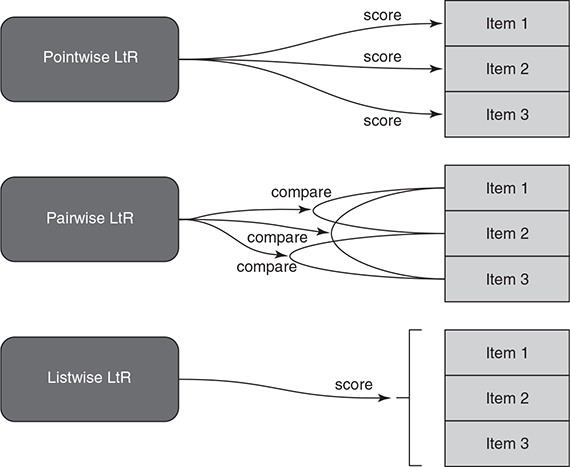

Figura . Learning to Rank Approchs [3]

# ML Learning To Rank

In [ ]:
%%time
df = (data.pipe(start_pipe)
          .pipe(to_explode)
          .pipe(get_events)
          .pipe(filter_reco_history)
          .sort_values(['DOCUMENT_ID', 'TIMESTAMP'], ascending=[True, False])
          .pipe(ranking_format)
          )
df.columns = ['_'.join(col) for col in df.columns]

df = (df
          .loc[lambda d:d['RECOS_search'].notnull()]
          .assign(SEARCH=(lambda d:d['RECOS_search'].apply(lambda x:x[0])),
                  LEN_SEARCH=(lambda d:d['SEARCH'].apply(lambda x:len(x.split()))),
                  LEN_ITEMS=(lambda d:d['RECOS_view'].apply(len)),

                 )
          .loc[lambda d:d['LEN_ITEMS']>9]
          .loc[lambda d:d['LEN_SEARCH']>2]
          .assign(SEARCH=(lambda d:d['SEARCH'].apply(lambda x:' '.join([w.lower().capitalize() for w in x.split()]))))
          .reset_index()
          .assign(ITEMS=(lambda d:d['RECOS_COUNTS_view'].apply(lambda x:list(set(x)))),
                  COUNTS=(lambda d:d['RECOS_COUNTS_view'].apply(lambda x:pd.Series(x).value_counts().to_dict())),
                  MAX_COUNT_ITEM=(lambda d:d['COUNTS'].apply(lambda x: max(x, key=x.get))),
                  LAST_ITEM=(lambda d:d['RECOS_view'].apply(lambda x:x[0]))

                  )
          .drop(['RECOS_search', 'RECOS_COUNTS_search', 'RECOS_COUNTS_view', 'LEN_SEARCH'], axis=1)
          .explode(['ITEMS'])
          .assign(TARGET=(lambda d:(d['ITEM_BOUGHT']==d['ITEMS']).astype('int8')))
          .merge(items[['ITEM_ID', 'TITLE', 'DOMAIN_ID', 'PRICE', 'CONDITION']],
                                      how='left',
                                      left_on=['ITEMS'],
                                      right_on=['ITEM_ID'],
                                      )
          .drop(['ITEM_ID', 'ITEM_BOUGHT', 'TIMESTAMPS_search', 'TIMESTAMPS_view', 'RECOS_view'], axis=1)

      )

CPU times: user 16min 30s, sys: 9.46 s, total: 16min 39s
Wall time: 16min 35s


In [ ]:
df.sample(3)

,DOCUMENT_ID,SEARCH,LEN_ITEMS,ITEMS,COUNTS,MAX_COUNT_ITEM,LAST_ITEM,TARGET,TITLE,DOMAIN_ID,PRICE,CONDITION
425217,373349,Skate Hoverboard Verde,71,2008799,"{1648720: 4, 897168: 4, 1233932: 4, 1180066: 3...",1648720,910646,0,Apartamento Pronto Para Morar No Condomínio Co...,MLB-INDIVIDUAL_APARTMENTS_FOR_SALE,945000.00,not_specified
237500,209116,Cropped Viscose Manga Longa Amarrar,50,1359409,"{909133: 4, 354147: 3, 1451576: 2, 1919940: 2,...",909133,516207,0,Body Feminino Bruna Marquezine Manga Longa Com...,MLB-BODYSUITS_AND_CATSUITS,34.99,new
42599,37630,Tapetes Carro Alfombra,17,1744575,"{1744575: 9, 2081343: 4, 56684: 3, 1425924: 2,...",1744575,1425924,0,Faro Derecho Honda Civic 1996 1997 1998 96 97 98,MLM-AUTOMOTIVE_HEADLIGHTS,929.00,new


## TIP 3: Use Previews Knowledge as Features

Hacer un baseline no solo permite cuantificar la mejora implementando un modelo de ML, es una gran forma de generar hipotesis y entender el dataset. Este conocimiento adquirido se puede convertir en Features

# FEATURES

In [ ]:
from rank_bm25 import BM25Okapi

In [ ]:
def new_features(dataframe):

  # RULES
  dataframe['ITEM_VIEWS'] = dataframe.apply(lambda x:x['COUNTS'][x['ITEMS']], axis=1)
  dataframe['IS_MAX_COUNT'] = (dataframe['MAX_COUNT_ITEM'] == dataframe['ITEMS']).astype('int8')
  dataframe['IS_LAST_VIEW_ITEM'] = (dataframe['LAST_ITEM'] == dataframe['ITEMS']).astype('int8')

  # Feature Engineering
  dataframe['LEN_SEARCH'] = dataframe['SEARCH'].apply(lambda x:len(x.split()))
  dataframe['LEN_ITEM_TITLE'] = dataframe['TITLE'].apply(lambda x:len(x.split()))
  dataframe['RATIO_TXT'] = dataframe['LEN_ITEM_TITLE'] / dataframe['LEN_SEARCH']
  dataframe['SITE'] = dataframe['DOMAIN_ID'].fillna('None').apply(lambda x:x.split('-')[0])
  dataframe['DOMAIN_ID'] = dataframe['DOMAIN_ID'].fillna('-NA').apply(lambda x:x.split('-')[1])


  # COSINE SIMILARITY
  result_search = search_emb_pipeline.fit_transform(dataframe)
  dataframe['SEARCH_EMB'] = result_search.tolist()
  result_items = text_emb_pipeline.fit_transform(dataframe)
  dataframe['ITEM_TITLE_EMB'] = result_items.tolist()
  dataframe['COSINE_SIMILARITY'] = dataframe.apply(lambda x:1-cosine(x['SEARCH_EMB'], x['ITEM_TITLE_EMB']), axis=1)

  # BM25
  bm25_groups = dataframe.groupby(['DOCUMENT_ID']).apply(get_bm25).to_frame('BM25').explode(['BM25'])
  dataframe['BM25'] = pd.to_numeric(bm25_groups['BM25'].values)

  return dataframe



def get_bm25(dataframe):

  tokenized_corpus_tmp = dataframe['TITLE'].apply(lambda x:x.split()).values.tolist()

  bm25_calculator = BM25Okapi(tokenized_corpus_tmp)

  tokenized_query = dataframe['SEARCH'].iloc[0].split()

  return bm25_calculator.get_scores(tokenized_query)

def drop_unused_features(dataframe):

  dataframe = dataframe.drop(columns=['COUNTS',	'MAX_COUNT_ITEM',
                                      'LAST_ITEM', 'SEARCH_EMB',
                                      'ITEM_TITLE_EMB'])

  return dataframe

In [ ]:
%%time
data_rank =(df.pipe(start_pipe)
        .pipe(new_features)
        .pipe(drop_unused_features)

)


CPU times: user 12min 27s, sys: 32.8 s, total: 13min
Wall time: 11min 34s


In [ ]:
data_rank.head(5)

,DOCUMENT_ID,SEARCH,LEN_ITEMS,ITEMS,TARGET,TITLE,DOMAIN_ID,PRICE,CONDITION,ITEM_VIEWS,IS_MAX_COUNT,IS_LAST_VIEW_ITEM,LEN_SEARCH,LEN_ITEM_TITLE,RATIO_TXT,SITE,COSINE_SIMILARITY,BM25
0,22,Camera Ip Intelbras Ic3,13,1202692,0,Câmera De Segurança Wi Fi Hd Mibo Ic3,SURVEILLANCE_CAMERAS,179.9,new,1,0,1,4,8,2.00,MLB,0.640809,0.373596
1,22,Camera Ip Intelbras Ic3,13,185736,0,Câmera Intelbras Mibo Wifi Hd 720p Ic3 Micro-sd,SURVEILLANCE_CAMERAS,183.0,new,1,0,0,4,8,2.00,MLB,0.654120,0.747192
2,22,Camera Ip Intelbras Ic3,13,1617774,0,Câmera Segurança Intelbras Ip Wifi Hd 720p Vis...,SURVEILLANCE_CAMERAS,259.0,new,1,0,0,4,9,2.25,MLB,0.489719,0.502938
3,22,Camera Ip Intelbras Ic3,13,898478,0,Camera Intelbras Infra Hdcvi 720p Hd Vhd 1010b...,SURVEILLANCE_CAMERAS,148.0,new,1,0,0,4,12,3.00,MLB,0.581440,2.218078
4,22,Camera Ip Intelbras Ic3,13,1515122,0,Câmera Ip Intelbras Ic3 Wifi + Micro Sd 32gb C...,SURVEILLANCE_CAMERAS,159.0,new,19,1,0,4,11,2.75,MLB,0.651423,0.783063


In [ ]:
(data_rank.select_dtypes('number')
    .drop(columns=['DOCUMENT_ID', 'LEN_ITEMS', 'LEN_SEARCH'])
    .groupby(['TARGET'])
    .mean()

 )

,PRICE,ITEM_VIEWS,IS_MAX_COUNT,IS_LAST_VIEW_ITEM,LEN_ITEM_TITLE,RATIO_TXT,COSINE_SIMILARITY,BM25
TARGET,,,,,,,,
0,45296.672743,1.744476,0.029927,0.032879,8.878664,2.542870,0.274903,0.550008
1,443.126056,4.940387,0.381303,0.320265,9.259365,2.649001,0.338526,0.939372


# TRAIN

## SPLIT
Hagamos un Split sencillo, no nos compliquemos para este WorkShop.

El unico Warning que siempre deben tener en estos problemas, es **NO** separar los registros del mismo GROUP_ID

Hagamos el confiable **70/30**

In [ ]:
data_rank['DOCUMENT_ID'].nunique()

21757

Sencillo no implica que no debamos considerar ciertas cosas, como por ejemplo : La cantidad de elementos a evaluar en cada grupo.

In [ ]:
data_rank['DOCUMENT_ID'].value_counts().describe().to_frame('DESCRIBE')

,DESCRIBE
count,21757.000000
mean,21.673852
std,13.374906
min,10.000000
25%,13.000000
50%,17.000000
75%,26.000000
max,147.000000


In [ ]:
data_rank = data_rank.assign(LEN_GROUP=(lambda d:pd.qcut(d['LEN_ITEMS'], 4, labels=False)))

In [ ]:
data_rank.groupby(['LEN_GROUP']).agg(NRO=('DOCUMENT_ID', 'nunique'),
                                     LEN_ITEMS=('LEN_ITEMS', 'mean')
                                     )

,NRO,LEN_ITEMS
LEN_GROUP,,
0,10220,12.899689
1,5483,20.211438
2,3831,30.781443
3,2223,56.774580


In [ ]:
from sklearn.model_selection import StratifiedGroupKFold
from itertools import chain

In [ ]:
%%time
training_index = []
testing_index = []
sgkf = StratifiedGroupKFold(n_splits=3)

# Por practicidad usaremos el ultimo Fold para Hacer Train y Test..  Pero hacer CV siempre es buena idea.
for train_ind, test_ind in sgkf.split(data_rank, data_rank['LEN_GROUP'], data_rank['DOCUMENT_ID']):
    train_index = train_ind
    test_index = test_ind

CPU times: user 4.19 s, sys: 7.7 ms, total: 4.2 s
Wall time: 4.19 s


In [ ]:
pd.concat([data_rank.loc[train_index]['DOCUMENT_ID'].value_counts().describe().to_frame('TRAIN'),
           data_rank.loc[test_ind]['DOCUMENT_ID'].value_counts().describe().to_frame('TEST')
           ], axis=1)

,TRAIN,TEST
count,14505.000000,7252.000000
mean,21.673423,21.674710
std,13.375996,13.373648
min,10.000000,10.000000
25%,13.000000,13.000000
50%,17.000000,17.000000
75%,26.000000,26.000000
max,147.000000,128.000000


In [ ]:
train = data_rank.loc[train_index].copy()
test  = data_rank.loc[test_index].copy()

In [ ]:
train.sample(4)

,DOCUMENT_ID,SEARCH,LEN_ITEMS,ITEMS,TARGET,TITLE,DOMAIN_ID,PRICE,CONDITION,ITEM_VIEWS,IS_MAX_COUNT,IS_LAST_VIEW_ITEM,LEN_SEARCH,LEN_ITEM_TITLE,RATIO_TXT,SITE,COSINE_SIMILARITY,BM25,LEN_GROUP
274150,240459,Protecao Cabelo Carro,12,1651984,0,Suporte Transbike Pop Básico De Porta Malas P/...,BICYCLE_ACCESSORIES_AND_SPARE_PARTS,74.90,new,2,0,0,3,10,3.333333,MLB,0.178393,0.000000,0
277667,243592,Cuba Sobrepor Amarela,14,457713,0,Cuba De Apoio / Sobrepor Quadrada Para Banheir...,BATHROOM_SINKS,89.90,new,5,0,0,3,9,3.000000,MLB,0.466336,2.768635,0
207830,183056,Ledlenser Mt 14,51,1261921,0,Wattimetro Voltimetro Amperimetro Dc 100v 10a ...,CLAMP_METERS,111.25,new,1,0,0,3,9,3.000000,MLB,0.221337,0.000000,3
14023,13308,Amd Radeon Hd5450 1gb,30,234965,0,Processador Intel Core I5 9400f 2.90ghz (4.10g...,COMPUTER_PROCESSORS,1119.00,new,2,0,0,4,13,3.250000,MLB,0.403393,0.000000,2


In [ ]:
FEATURES = [
 'BM25',
 'COSINE_SIMILARITY',
 'IS_LAST_VIEW_ITEM',
 'IS_MAX_COUNT',
 'ITEM_VIEWS',
 'RATIO_TXT',
 'DOMAIN_ID'
 ]

## .fit


Existen varias librerias que ya tiene implementados los algoritmos de Ranking , las más utilizadas son :

```python

LGBMRanker()
CatBoostRanker()
XGBRanker()

```

y claro!.... no olvidemos todas las que usan NN.

```python
tensorflow_ranking #TensorFlow
allRank #PyTorch
```

### LightGBM

In [ ]:
from lightgbm import LGBMRanker

In [ ]:
X_train = train[FEATURES].assign(DOMAIN_ID=lambda d:d['DOMAIN_ID'].astype('category'))
y_train = train['TARGET']
train_group = train.groupby('DOCUMENT_ID').size().tolist()
X_test  = test[FEATURES].assign(DOMAIN_ID=lambda d:d['DOMAIN_ID'].astype('category'))

In [ ]:
ranker = LGBMRanker(boosting_type='gbdt',
                    learning_rate=0.01,
                    n_estimators=200,
                    num_leaves=61,
                    max_depth=7,
                    min_child_samples=50,
                    objective="rank_xendcg",
                    metric="ndcg",
                    force_row_wise=True,
                    subsample=1.0,
                    reg_alpha=0.0,
                    reg_lambda=0.0,
                    random_state=42,
                    n_jobs=None,
                    categorical_feature=['DOMAIN_ID']
                    )

In [ ]:
%%time
ranker.fit(X_train, y_train, group=train_group)

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1873: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1893: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=DOMAIN_ID, categorical_column=6 will be ignored. Current value: categorical_feature=DOMAIN_ID
[LightGBM] [Info] Total Bins 2702
[LightGBM] [Info] Number of data points in the train set: 314373, number of used features: 7
CPU times: user 8.51 s, sys: 35.1 ms, total: 8.54 s
Wall time: 2.17 s


LGBMRanker(categorical_feature=['DOMAIN_ID'], force_row_wise=True,
           learning_rate=0.01, max_depth=7, metric='ndcg', min_child_samples=50,
           n_estimators=200, num_leaves=61, objective='rank_xendcg',
           random_state=42)

In [ ]:
%%time
result = test.copy().assign(SCORE=(ranker.predict(X_test)))

CPU times: user 2.08 s, sys: 1.84 ms, total: 2.08 s
Wall time: 567 ms


In [ ]:
result_relevance  = (result.sort_values(['DOCUMENT_ID', 'SCORE'], ascending=False)
                                   .groupby(['DOCUMENT_ID'])
                                   .agg(PREDICT_ORDER=('ITEMS', list),
                                        PREDICT_RELEVANCE=('TARGET', list)

                                        )
                                   .merge((result.sort_values(['DOCUMENT_ID', 'TARGET'], ascending=False)
                                      .groupby(['DOCUMENT_ID'])
                                      .agg(TRUE_ORDER=('ITEMS', list),
                                          TRUE_RELEVANCE=('TARGET', list)

                                          )
                                      ),
                            left_index=True,
                            right_index=True

                             )


                    )

In [ ]:
%%time
ndcg_score(result_relevance['TRUE_RELEVANCE'].apply(pd.Series).fillna(0).values,

           result_relevance['PREDICT_RELEVANCE'].apply(pd.Series).fillna(0).values
           )

CPU times: user 4.29 s, sys: 151 ms, total: 4.44 s
Wall time: 4.32 s


0.5424987418804684

### XGB

In [ ]:
from xgboost import XGBRanker

In [ ]:
ranker_xgb = XGBRanker(n_estimators=100,
                       tree_method="hist",
                       lambdarank_num_pair_per_sample=16,
                       objective="rank:ndcg",
                       lambdarank_pair_method="topk",
                       enable_categorical=True,
                   )

In [ ]:
%%time
ranker_xgb.fit(X_train, y_train, qid=train['DOCUMENT_ID'])

CPU times: user 19.7 s, sys: 1 s, total: 20.7 s
Wall time: 2.66 s


XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device=None,
          early_stopping_rounds=None, enable_categorical=True, eval_metric=None,
          feature_types=None, gamma=None, grow_policy=None,
          importance_type=None, interaction_constraints=None,
          lambdarank_num_pair_per_sample=16, lambdarank_pair_method='topk',
          learning_rate=None, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=100,
          n_jobs=None, ...)

In [ ]:
%%time
result_xgb = test.copy().assign(SCORE=(ranker_xgb.predict(X_test)))

result_relevance_xgb  = (result_xgb.sort_values(['DOCUMENT_ID', 'SCORE'], ascending=False)
                                   .groupby(['DOCUMENT_ID'])
                                   .agg(PREDICT_ORDER=('ITEMS', list),
                                        PREDICT_RELEVANCE=('TARGET', list)

                                        )
                                   .merge((result_xgb.sort_values(['DOCUMENT_ID', 'TARGET'], ascending=False)
                                      .groupby(['DOCUMENT_ID'])
                                      .agg(TRUE_ORDER=('ITEMS', list),
                                          TRUE_RELEVANCE=('TARGET', list)

                                          )
                                      ),
                            left_index=True,
                            right_index=True

                             )


                    )

CPU times: user 2.27 s, sys: 4.62 ms, total: 2.27 s
Wall time: 982 ms


In [ ]:
%%time
ndcg_score(result_relevance_xgb['TRUE_RELEVANCE'].apply(pd.Series).fillna(0).values,

           result_relevance_xgb['PREDICT_RELEVANCE'].apply(pd.Series).fillna(0).values
           )

CPU times: user 4.04 s, sys: 109 ms, total: 4.15 s
Wall time: 4.07 s


0.5437285839721877

# Next Steps


Como mejorar la solución.

DATOS :

* Limpieza
* Features
* Modelos más Play
  * NN

## Otros Steps

### RESTRICCIONES

Que pasaria si por cada query deberia :
* 10 items recomendados finales.
* Excluiar Items ya comprados.
* ....
* ..
* .

Re-RANKER

# END
Gracias por escucharme, ojala les gustara... llevense los TIPS y cualquier cosa me preguntan.

<img src='https://media2.giphy.com/media/nG0MqEAopKJy0nFECr/giphy.gif?cid=ecf05e47u6utmfk0hfg4n38vk6q7iji3xw36gcxuuahjzxlh&ep=v1_gifs_search&rid=giphy.gif&ct=g' alt='how to  a gif to your page' height='350px'>